In [1]:
import sys
sys.path.append("../")
import matplotlib.pyplot as plt

In [2]:
import os
#os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch

# Format input data

In [149]:
patient = 'R319'
PATH = "../../Data/echidna3/"
path = os.path.join(PATH, patient + ".h5ad")
print(path)

../../Data/echidna3/R319.h5ad


In [150]:
w_path = os.path.join(PATH, "all_cellranger_w.csv")
w_path

'../../Data/echidna3/all_cellranger_w.csv'

In [151]:
from echidna.utils import *

In [152]:
W = read_W(w_path)

In [153]:
X = sc.read_h5ad(path)
X

AnnData object with n_obs × n_vars = 14909 × 22609
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'percent.rp', 'sample', 'patient', 'condition', 'barcode_orig', 'barcode_pat', 'samples_per_patient', 'timepoint', 'Before.During.After', 'Sample_J', 'Gender', 'Treatment_phase', 'Drug', 'tissue', 'Mutation', 'sample_group', 'predicted_doublets', 'doublet_scores', 'RNA_snn_res.0.8', 'seurat_clusters', 'clonotype_id', 'chain', 'v_gene', 'd_gene', 'j_gene', 'c_gene', 'frequency', 'proportion', 'cdr3s_aa', 'cdr3s_nt', 'inkt_evidence', 'mait_evidence', 'tcr', 'mait', 'inkt', 'both_chains', 'clone_size', 'mait_inkt', 'celltype_bped_main', 'celltype_bped_fine', 'celltype_hpca_main', 'celltype_hpca_fine', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'original_total_counts', 'log10_origi

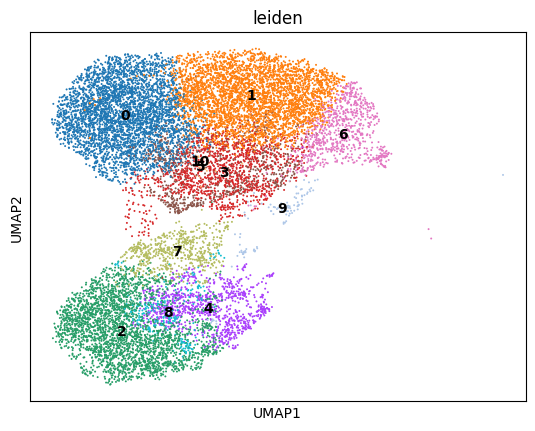

In [154]:
sc.pl.umap(X, color=['leiden'], legend_loc='on data')

In [155]:
X_obs, W_obs, z_obs, pi_obs = prepare_input(X, W, sample_name=patient, 
                                            timepoints=['pre', 'on'], n_subsamples=3000, device="cpu")
print(X_obs.shape)
print(W_obs.shape)
print(z_obs.shape)
print(pi_obs.shape)

torch.Size([2, 3000, 22609])
torch.Size([2, 22609])
torch.Size([2, 3000])
torch.Size([2, 11])


# Train model

In [156]:
from echidna.model import Echidna
from echidna.train import train_Echidna
from echidna.utils import ModelConfig
from echidna.eval import *

In [157]:
config = ModelConfig()
config.num_cells = X_obs.shape[1]
config.num_genes = X_obs.shape[-1]
config.num_timepoints = X_obs.shape[0]
config.num_clusters = pi_obs.shape[-1]
config.q_corr_init = 1e-2
config.q_shape_rate_scaler = 10.0
config.eta_mean_init = 2.0
config.lkj_concentration = 1.0

In [158]:
echidna = Echidna(config, mode="MT", device="cpu")

In [159]:
echidna, loss = train_Echidna(echidna, X_obs, W_obs, pi_obs, z_obs, lr=0.1, n_epochs=500)

100%|██████████| 500/500 [03:53<00:00,  2.14it/s]


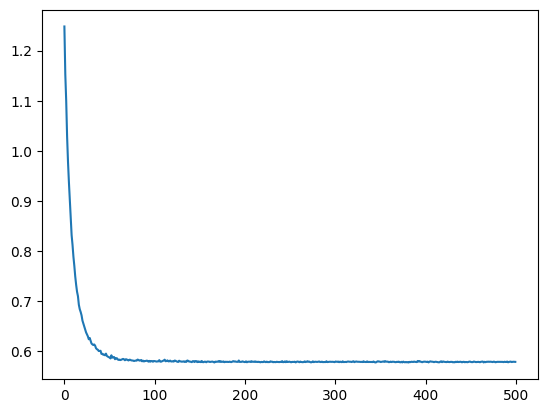

In [160]:
plt.plot(loss)

# Look at trained model

In [161]:
import torch.nn.functional as F
from echidna.eval import *
from echidna.params import *
import seaborn as sns
import matplotlib.pyplot as plt

In [162]:
eta = eta_posterior_estimates(echidna=echidna, X=X_obs, W=W_obs, pi=pi_obs, z=z_obs)

In [163]:
eta.shape

torch.Size([11, 22609])

In [24]:
c_on, c_pre = c_posterior_estimates(eta, mt=True) # FLIP THIS FOR R310

In [26]:
cov = cov_posterior_estimate(inverse_gamma=False)
cov.shape

(12, 12)

In [27]:
c_shape = pyro.param('c_shape')
lib_on = X_obs[0, :, :].sum(-1, keepdim=True) * 1e-5
lib_pre = X_obs[1, :, :].sum(-1, keepdim=True) * 1e-5
z_on = z_obs[0, :]
z_pre = z_obs[1, :]

In [28]:
X_learned_on = sample_X(X_obs.numpy(), c_on, eta, z_on.numpy(), lib_on)
X_learned_pre = sample_X(X_obs.numpy(), c_pre, eta, z_pre.numpy(), lib_on)

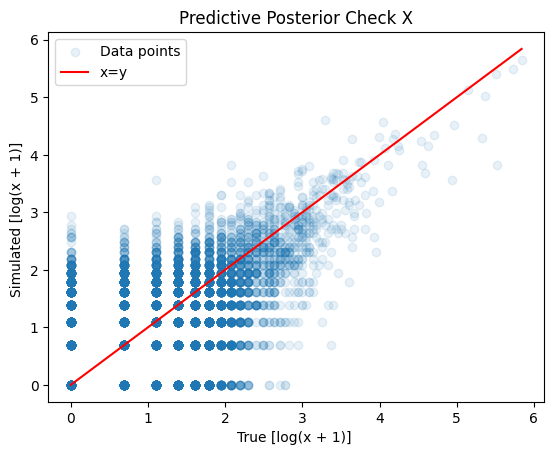

In [31]:
pred_posterior_check(X_learned_on, X_obs[0, :, :].numpy(), log_scale=True, name='X', R_val=False)

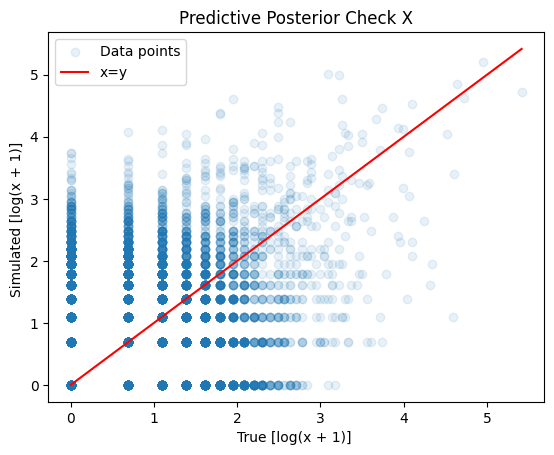

In [32]:
pred_posterior_check(X_learned_pre, X_obs[-1, :, :].numpy(), log_scale=True, name='X', R_val=False)

In [33]:
W_learned = np.array(sample_W(pi_obs, eta))
W_obs_np = W_obs.numpy()

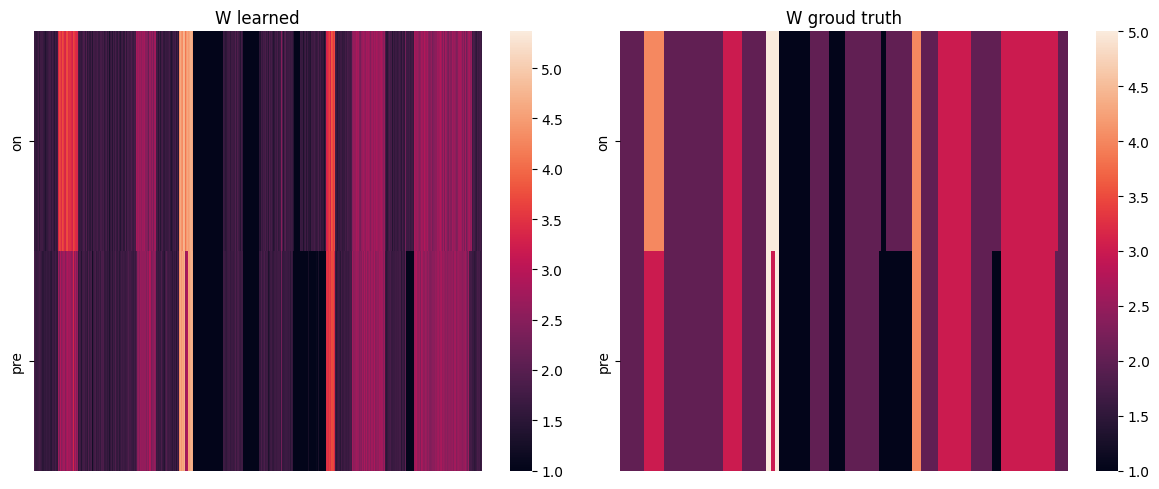

In [164]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the first heatmap
sns.heatmap(W_learned, ax=axes[0], vmin=1)
axes[0].set_title('W learned')
axes[0].set_xticks([])
axes[0].set_yticklabels(['on', 'pre'])

# Plot the second heatmap
sns.heatmap(W_obs_np, ax=axes[1])
axes[1].set_title("W groud truth")
axes[1].set_xticks([])
axes[1].set_yticklabels(['on', 'pre'])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

<Figure size 100x100 with 0 Axes>

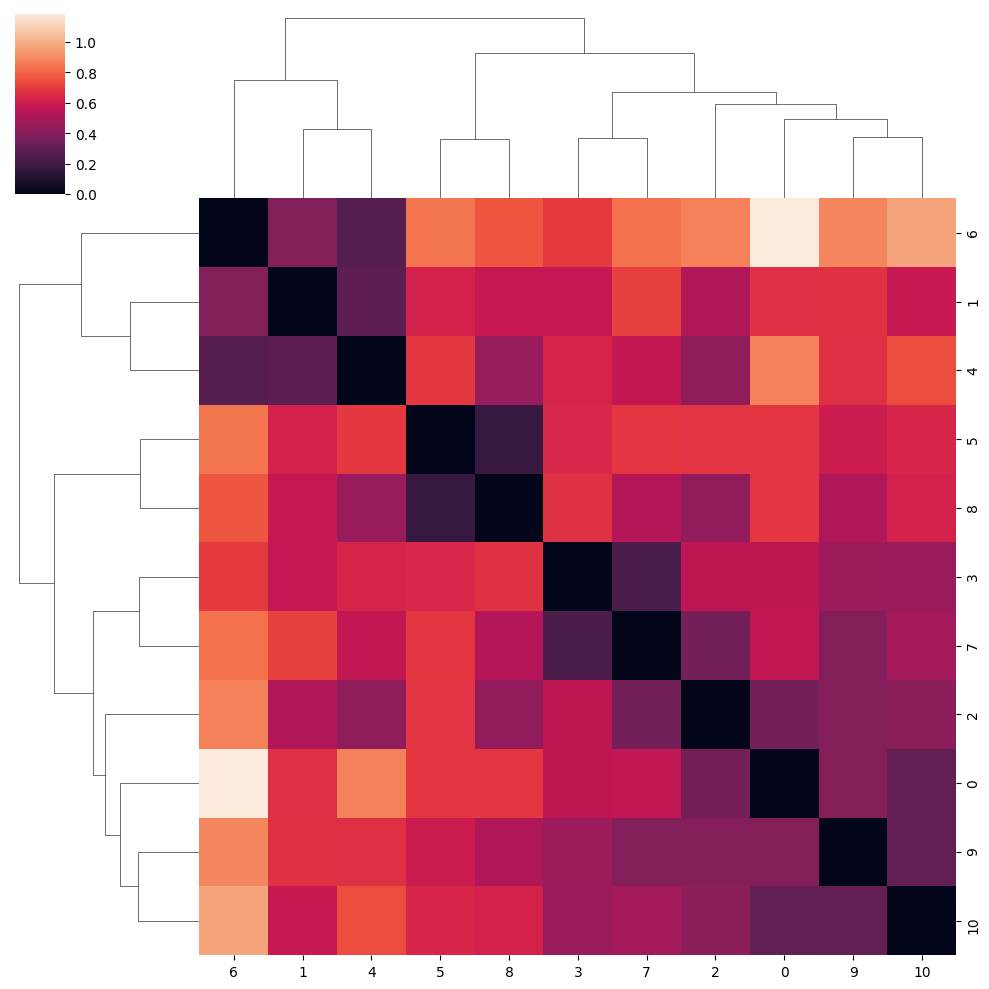

In [185]:
plt.figure(figsize=(1, 1)) 
sns.clustermap(1-torch.corrcoef(eta).cpu().detach().numpy())
plt.show()

In [166]:
from echidna.eval import eta_cov_tree, assign_clones, learned_cov

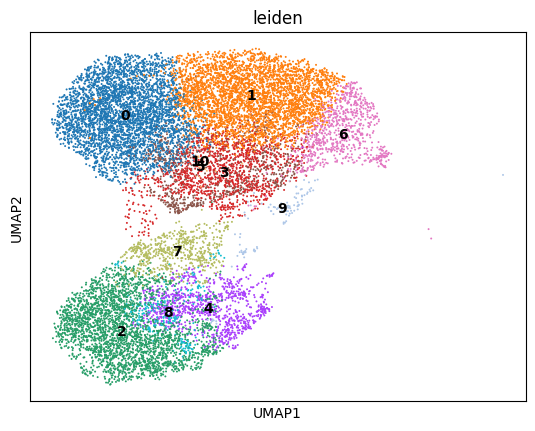

In [167]:
sc.pl.umap(X, color=['leiden'], legend_loc='on data')

In [168]:
from echidna.eval import eta_cov_tree_elbow_thresholding

Knee point:  9
Threshold:  0.4104680806366006


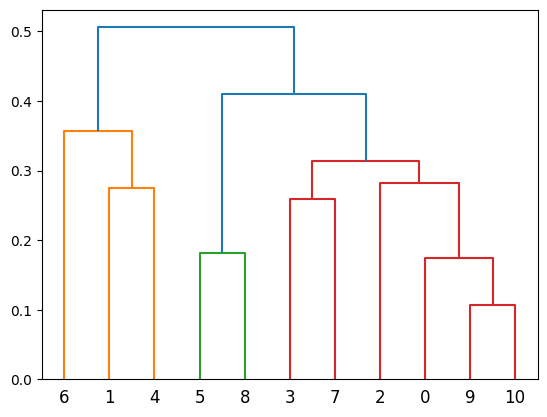

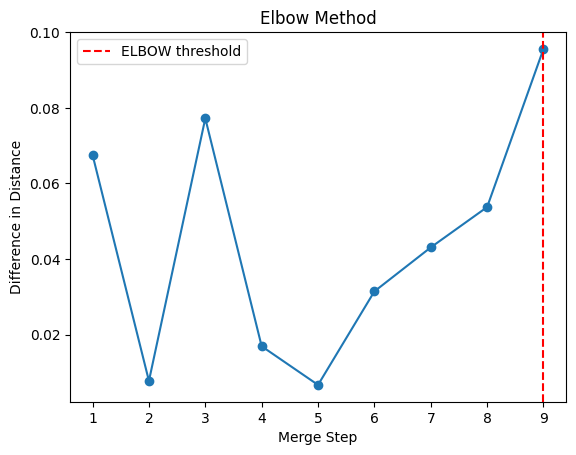

In [169]:
dn = eta_cov_tree_elbow_thresholding(eta, plot_elbow=True)

In [170]:
assign_clones(dn, X)

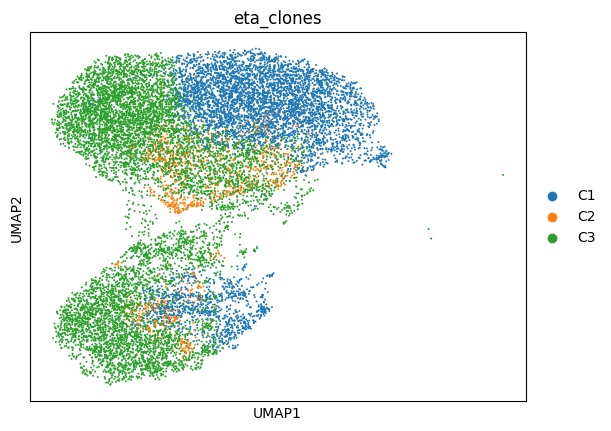

In [171]:
sc.pl.umap(X, color=['eta_clones'])

In [172]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, to_tree

In [173]:
Z = linkage(1 - torch.corrcoef(eta).cpu().detach().numpy(), method='average')

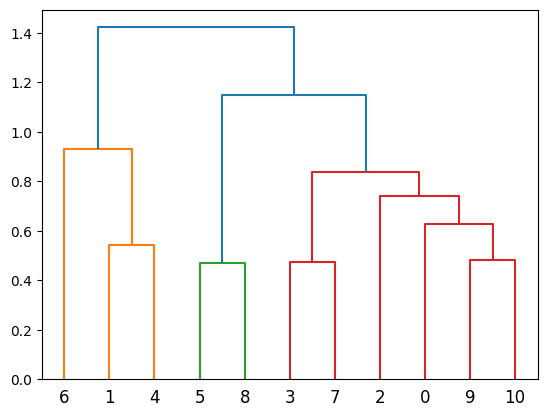

In [175]:
dn = dendrogram(Z, color_threshold=1.0)

In [176]:
assign_clones(dn, X)

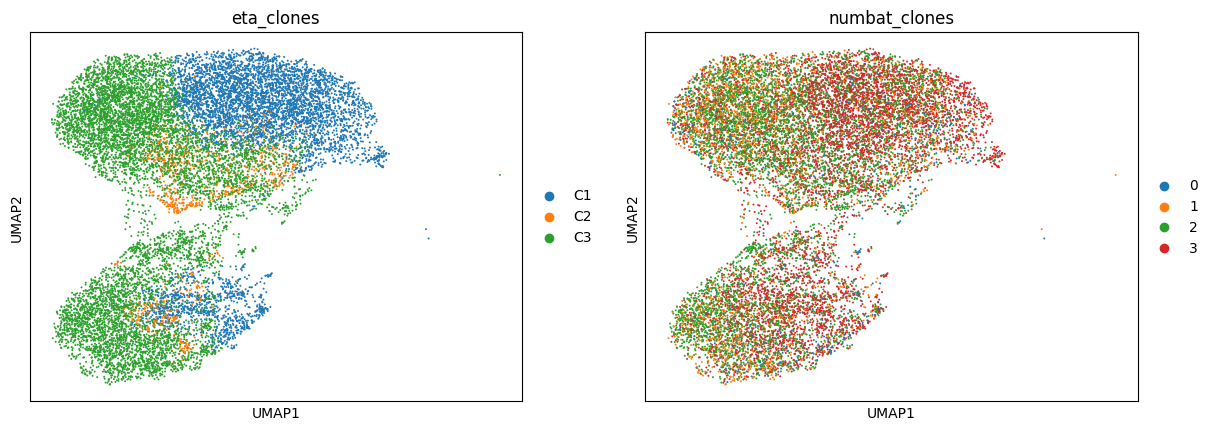

In [182]:
sc.pl.umap(X, color=['eta_clones', 'numbat_clones'])

In [183]:
def eta_corr_tree(eta, thres):
    eta_corr = torch.corrcoef(eta).cpu().detach().numpy()
    dist_mat = 1 - eta_corr
    Z = linkage(dist_mat, 'average')
    fig = plt.figure(figsize=(6, 3))
    dn = dendrogram(Z, color_threshold=thres)
    return dn


def eta_corr_tree_elbow_thresholding(eta, plot_elbow=False):
    eta_corr = torch.corrcoef(eta).cpu().detach().numpy()
    dist_mat = 1 - eta_corr
    Z = linkage(dist_mat, 'average')
    distance = Z[:,  2]
    differences = np.diff(distance)
    knee_point = np.argmax(differences)
    threshold = distance[knee_point]
    print("Knee point: ", knee_point + 1)
    print("Threshold: ", threshold)
    dn = dendrogram(Z, color_threshold=threshold)
    if plot_elbow:
        plt.figure()
        plt.plot(range(1, len(differences) + 1), differences, marker='o')
        plt.axvline(x=knee_point + 1, linestyle='--', label='ELBOW threshold', color='red')
        plt.legend()
        plt.xlabel('Merge Step')
        plt.ylabel('Difference in Distance')
        plt.title('Elbow Method')
        plt.show()
    return dn

Knee point:  9
Threshold:  1.1475092199804577


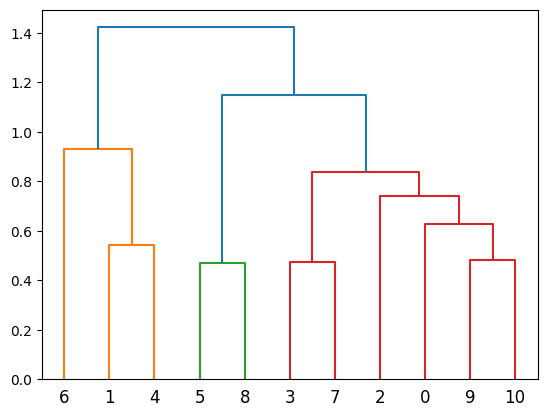

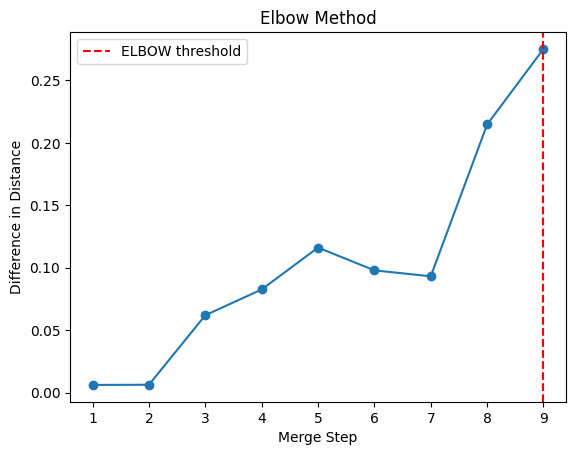

In [184]:
dn = eta_corr_tree_elbow_thresholding(eta, plot_elbow=True)

In [178]:
from scipy.cluster.hierarchy import linkage, cut_tree, dendrogram

In [179]:
n_clusters = 4

In [180]:
eta.shape

torch.Size([11, 22609])

In [125]:
import torch
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt

def iterative_adaptive_clustering(eta, n_iterations, adaptive_cutoff):
    all_clusters = []
    data = torch.cov(eta).cpu().detach().numpy()
    current_labels = None
    
    original_indices = np.arange(data.shape[0])  # Track original indices
    
    for i in range(n_iterations):
        print(f"Iteration {i + 1}")

        # cluster
        Z = linkage(data, 'average')

        # get current assignments
        base_cutoff = adaptive_cutoff[i]
        clusters = fcluster(Z, base_cutoff, criterion='distance')
        print(f"Iteration {i + 1} - Cluster labels:", clusters)
        
        if i != 0:
            dn = dendrogram(Z, color_threshold=base_cutoff, labels=current_labels)
        else:
            dn = dendrogram(Z, color_threshold=base_cutoff)
        
        current_labels = dn['ivl']
        plt.show()

        # remove most obvious clusters
        cluster_to_remove = np.bincount(clusters).argmin()
        dim_to_remove = np.where(clusters == cluster_to_remove + 1)[0]
        dim_to_remove_str = [str(original_indices[d]) for d in dim_to_remove]
        print("Removing indices:", dim_to_remove_str)

        # Remove the points in the largest cluster
        data = np.delete(data, dim_to_remove, axis=0)  # Remove rows
        data = np.delete(data, dim_to_remove, axis=1)  # Remove columns
        current_labels = [l for l in current_labels if l not in dim_to_remove_str]

        # Update original indices
        original_indices = np.delete(original_indices, dim_to_remove)

        # If no data left, break the loop
        if len(data) == 0:
            print("No data left to cluster.")
            break
        
        all_clusters.append(clusters)

    return all_clusters

Iteration 1
Iteration 1 - Cluster labels: [2 2 2 2 2 1 2 2 2 1 2 2]


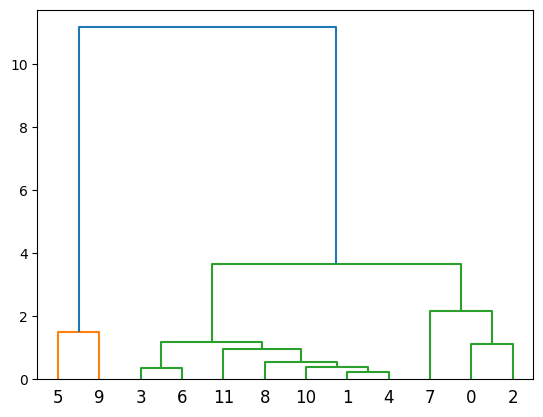

Removing indices: ['5', '9']
Iteration 2
Iteration 2 - Cluster labels: [1 2 1 2 2 2 2 2 2 2]


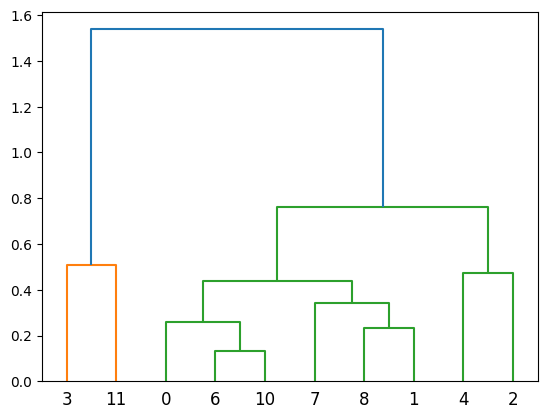

Removing indices: ['0', '2']
Iteration 3
Iteration 3 - Cluster labels: [2 2 2 2 1 2 2 1]


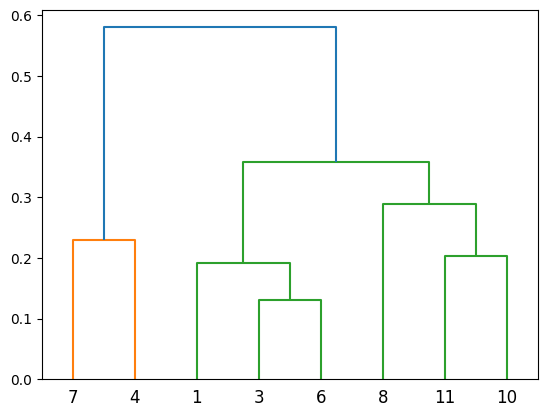

Removing indices: ['7', '11']


In [127]:
clst = iterative_adaptive_clustering(eta, n_iterations=3, adaptive_cutoff=[4.0, 1.0, 0.5])